# MLB Team Search (1998–2024)

This Python script allows you to search for an MLB team's season performance data from 1998 to 2024 using an SQLite in-memory database.

---

## 🔍 What It Does

- Loads and cleans historical MLB standings and stats from `mlb_1998_2024.csv`
- Standardizes team names (e.g., "Tampa Bay Devil Rays" → "Tampa Bay Rays")
- Loads the data into a temporary SQLite database
- Prompts the user to enter a **team name** (or partial name) and **year**
- Queries the database for matching results and displays the team’s stats for that season

---

## 🧪 Example Usage

Results for 'Yankees' in 2009:

   team_name  year  wins  losses  winning_percentage  ...  [other stats]
0  New York Yankees  2009    103       59                 0.636             ...


In [55]:
import pandas as pd
import sqlite3

# Load and clean data
df = pd.read_csv("mlb_1998_2024.csv")

team_rename_dict = {
    "Tampa Bay Devil Rays": "Tampa Bay Rays",
    "Florida Marlins": "Miami Marlins",
    "Anaheim Angels": "Los Angeles Angels",
    "Montreal Expos": "Washington Nationals",
    "Cleveland Indians": "Cleveland Guardians"
}
df["team_name"] = df["team_name"].replace(team_rename_dict)

df.columns = df.columns.str.strip()
df["year"] = df["year"].astype(int)

# Create SQLite connection
conn = sqlite3.connect(":memory:")
df.to_sql("mlb", conn, index=False, if_exists="replace")

# User input
team = input("Enter a team name (e.g., Braves): ").strip()
year = input("Enter a year (e.g., 2022): ").strip()

# Make sure year is int
try:
    year = int(year)
except ValueError:
    print("Invalid year input. Please enter a number like 2022.")
    exit()

# SQL query using correct column name
query = """
SELECT *
FROM mlb
WHERE team_name LIKE ? AND year = ?
"""

# Execute query
result = pd.read_sql_query(query, conn, params=[f"%{team}%", year])

# Display result
if result.empty:
    print(f"\nNo results found for '{team}' in {year}. Check spelling or try part of the name.")
else:
    print(f"\nResults for '{team}' in {year}:\n")
    print(result)


Enter a team name (e.g., Braves):  Braves
Enter a year (e.g., 2022):  2021



Results for 'Braves' in 2021:

        team_name  year  wins  losses  winning_percentage  games_behind  \
0  Atlanta Braves  2021    88      73               0.547          18.5   

  wild_card_games_behind record_in_the_last_10_games current_streak  \
0                   None                         8-2             W2   

   runs_scored  runs_allowed  run_differential expected_win_loss_record  \
0          790           656               134                    94-67   

  record_at_home record_when_away record_against_top_50_percent  
0          42-38            46-35                         31-37  


# Top 5 MLB Teams by Winning Percentage (1998–2024)

This Python script allows you to explore the top 5 MLB teams by **winning percentage** in a given year between 1998 and 2024. It queries a SQLite database and visualizes the results with a bar chart.

---

## 🔍 What It Does

- Prompts the user to enter a **year**
- Runs a SQL query on an in-memory database to find the top 5 teams (by `winning_percentage`) for that year
- Displays the results in a table
- Generates a simple bar chart using `matplotlib`

---

## 🧪 Example Usage

```bash
Enter a year to find the top 5 teams by winning percentage: 2023

Top 5 teams by winning percentage in 2023:

      team_name  year  winning_percentage
   Atlanta Braves  2023             0.654
    LA Dodgers     2023             0.621
    Baltimore Orioles 2023         0.623
    ...


Enter a year to find the top 5 teams by winning percentage:  2023



Top 5 teams by winning percentage in 2023:

          team_name  year  winning_percentage
     Atlanta Braves  2023               0.642
  Baltimore Orioles  2023               0.623
Los Angeles Dodgers  2023               0.617
     Tampa Bay Rays  2023               0.611
  Milwaukee Brewers  2023               0.568


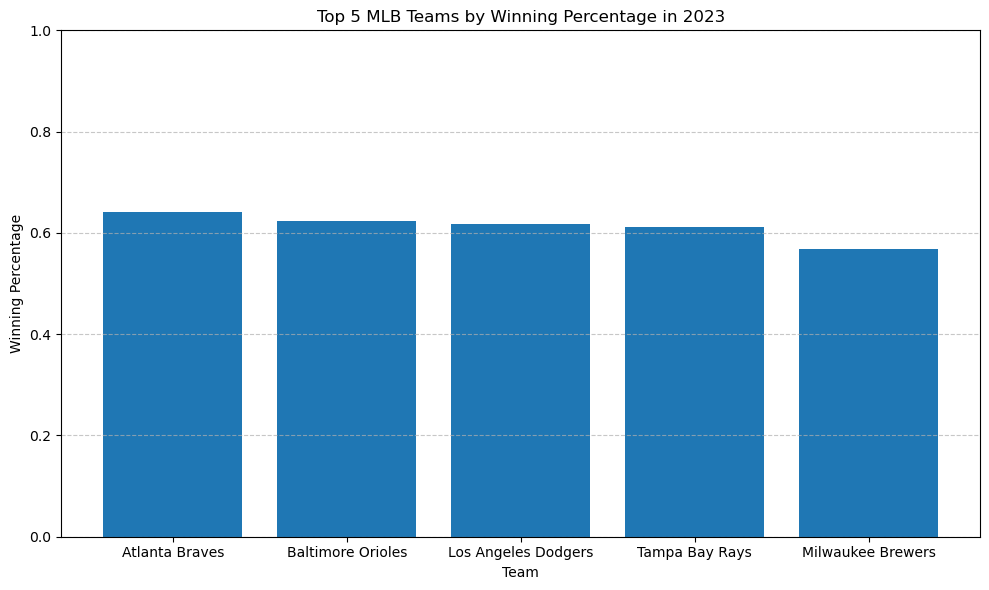

In [57]:
# Ask user for a year
year = input("Enter a year to find the top 5 teams by winning percentage: ").strip()

# Validate year input
try:
    year = int(year)
except ValueError:
    print("Invalid year. Please enter a number like 2022.")
    exit()

# Run SQL query
query = """
SELECT team_name, year, winning_percentage
FROM mlb
WHERE year = ?
ORDER BY winning_percentage DESC
LIMIT 5;
"""

result = pd.read_sql_query(query, conn, params=[year])

# Check and display results
if result.empty:
    print(f"No data found for year {year}.")
else:
    print(f"\nTop 5 teams by winning percentage in {year}:\n")
    print(result.to_string(index=False))

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(result["team_name"], result["winning_percentage"])
    plt.title(f"Top 5 MLB Teams by Winning Percentage in {year}")
    plt.xlabel("Team")
    plt.ylabel("Winning Percentage")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# MLB World Series Predictor Analysis (1998–2024)

This Python project explores how well regular-season statistics can predict the eventual World Series winner. It uses real MLB data from 1998 to 2024, merges it with World Series outcomes, and analyzes the predictive power of various stats using SQL ranking logic.

---

## ⚾ What It Does

- Loads and standardizes historical MLB team data (`mlb_1998_2024.csv`)
- Merges in World Series winner data from `World_Series_Data.csv`
- Flags which team won the World Series in each year
- For each stat (e.g. winning percentage, runs scored), it:
  - Ranks all teams per year
  - Checks if the World Series winner is among the **top 5 teams** by that stat
- Reports how many times each stat correctly included the champion

---

## 📊 Output Example

The script prints a table like:


0 winning_percentage 18 66.666667
1 run_differential 18 66.666667
2 wins 18 66.666667
3 runs_scored 14 51.851852
4 runs_allowed 10 37.037037



This means the champion was among the top 5 teams by winning percentage in **18 of 27** years (~66.7% of the time).


In [61]:
import pandas as pd
import sqlite3

# === TEAM NAME STANDARDIZATION ===
team_rename_dict = {
    "Tampa Bay Devil Rays": "Tampa Bay Rays",
    "Florida Marlins": "Miami Marlins",
    "Anaheim Angels": "Los Angeles Angels",
    "Montreal Expos": "Washington Nationals",
    "Cleveland Indians": "Cleveland Guardians",
    
    # Short → Full Names
    "Yankees": "New York Yankees",
    "Dodgers": "Los Angeles Dodgers",
    "Giants": "San Francisco Giants",
    "Cardinals": "St. Louis Cardinals",
    "Astros": "Houston Astros",
    "Braves": "Atlanta Braves",
    "Mets": "New York Mets",
    "Red Sox": "Boston Red Sox",
    "White Sox": "Chicago White Sox",
    "Rangers": "Texas Rangers",
    "Phillies": "Philadelphia Phillies",
    "Royals": "Kansas City Royals",
    "Cubs": "Chicago Cubs",
    "Nationals": "Washington Nationals",
    "Diamondbacks": "Arizona Diamondbacks",
    "Angels": "Los Angeles Angels",
    "Padres": "San Diego Padres",
    "Rockies": "Colorado Rockies",
    "Orioles": "Baltimore Orioles",
    "Blue Jays": "Toronto Blue Jays",
    "Brewers": "Milwaukee Brewers",
    "Pirates": "Pittsburgh Pirates",
    "Athletics": "Oakland Athletics",
    "Twins": "Minnesota Twins",
    "Tigers": "Detroit Tigers",
    "Reds": "Cincinnati Reds",
    "Mariners": "Seattle Mariners"
}

# === LOAD & CLEAN DATA ===
mlb_df = pd.read_csv("mlb_1998_2024.csv")
mlb_df.columns = mlb_df.columns.str.strip()
mlb_df["team_name"] = mlb_df["team_name"].str.strip().replace(team_rename_dict)
mlb_df["year"] = mlb_df["year"].astype(int)

winners_df = pd.read_csv("World_Series_Data.csv")
winners_df.columns = winners_df.columns.str.strip()
winners_df["world_series_winner"] = winners_df["world_series_winner"].str.strip().replace(team_rename_dict)
winners_df["year"] = winners_df["year"].astype(int)

# === MERGE AND FLAG WINNERS ===
merged_df = mlb_df.merge(winners_df, on="year", how="left")
merged_df["won_world_series"] = (merged_df["team_name"] == merged_df["world_series_winner"]).astype(int)
merged_df.drop(columns=["world_series_winner"], inplace=True)

# === LOAD INTO SQLITE ===
conn = sqlite3.connect(":memory:")
merged_df.to_sql("mlb", conn, index=False, if_exists="replace")

# === DEFINE STATS TO ANALYZE ===
stats_info = {
    "winning_percentage": "DESC",
    "runs_scored": "DESC",
    "runs_allowed": "ASC",  # lower is better
    "run_differential": "DESC",
    "wins": "DESC"
    # Add more if you want
}

total_years = merged_df["year"].nunique()
results = []

# === LOOP THROUGH STATS AND RANK ===
for stat, order in stats_info.items():
    query = f"""
    WITH ranked AS (
        SELECT 
            year,
            team_name,
            {stat},
            won_world_series,
            RANK() OVER (PARTITION BY year ORDER BY {stat} {order}) AS rank
        FROM mlb
    )
    SELECT COUNT(DISTINCT year) AS years_predicted
    FROM ranked
    WHERE rank <= 5 AND won_world_series = 1;
    """
    res = pd.read_sql_query(query, conn)
    years_predicted = res.iloc[0,0]
    accuracy = years_predicted / total_years * 100
    results.append({"stat": stat, "years_predicted": years_predicted, "accuracy_pct": accuracy})

# === SHOW RESULTS ===
results_df = pd.DataFrame(results).sort_values("accuracy_pct", ascending=False)
print(results_df)


                 stat  years_predicted  accuracy_pct
0  winning_percentage               18     66.666667
3    run_differential               18     66.666667
4                wins               18     66.666667
1         runs_scored               14     51.851852
2        runs_allowed               10     37.037037


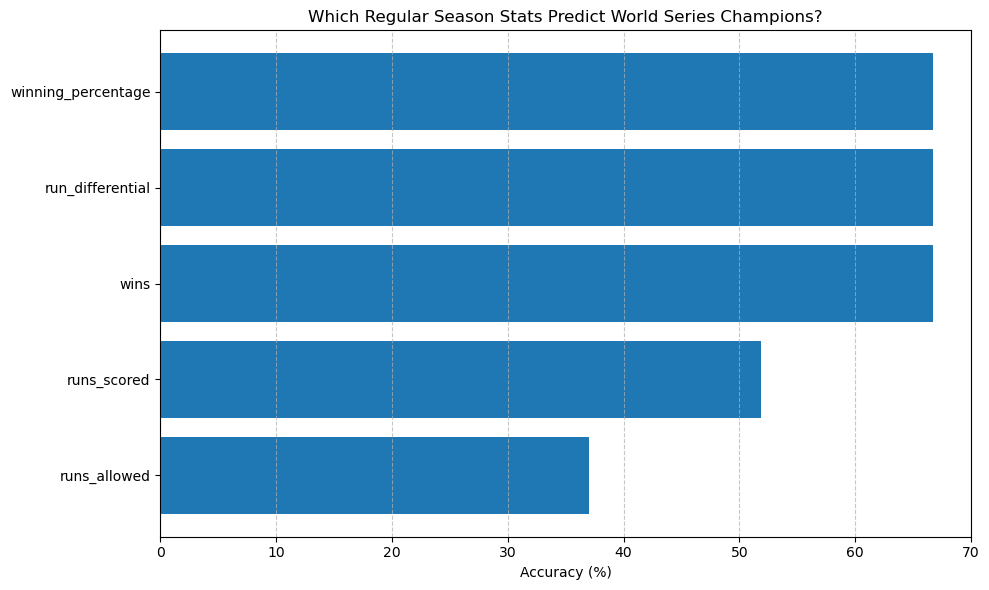

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(results_df["stat"], results_df["accuracy_pct"])
plt.xlabel("Accuracy (%)")
plt.title("Which Regular Season Stats Predict World Series Champions?")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
